# Generative Adverarial Network 

生成对抗网络包含了两个子网络：生成网络(Generator，简称G)和判别网络
(Discriminator，简称D)，其中生成网络G 负责学习样本的真实分布，判别网络D 负责将
生成网络采样的样本与真实样本区分开来。

In [7]:
import os
import glob

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [8]:
anime_path = glob.glob(r'D:\chrome_download\Deep-Learning-with-TensorFlow-book-master\Deep-Learning-with-TensorFlow-book-master\ch13\faces\*.jpg')
print('image nums:', len(anime_path))

image nums: 51223


In [24]:
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model

In [21]:
def make_generator_model(z_dim):
    filters = 64
    model = tf.keras.Sequential([])
    
    model.add(layers.Reshape((1, 1, z_dim)))
    model.add(layers.ReLU())
    # 转置卷积-BN-激活函数:(b, 4, 4, 512)
    model.add(layers.Conv2DTranspose(filters=filters * 8, kernel_size=4, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 8, 8, 256)
    model.add(layers.Conv2DTranspose(filters=filters * 4, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 16, 16, 128)
    model.add(layers.Conv2DTranspose(filters=filters * 2, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 32, 32, 64)
    model.add(layers.Conv2DTranspose(filters=filters * 1, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 64, 64, 3)
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh'))
    return model

In [38]:
generator = make_generator_model(100)
# generator = Generator()
generator.build(input_shape=(None, 100))

In [39]:
generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          multiple                  0         
_________________________________________________________________
re_lu_7 (ReLU)               multiple                  0         
_________________________________________________________________
conv2d_transpose_45 (Conv2DT multiple                  819200    
_________________________________________________________________
batch_normalization_36 (Batc multiple                  2048      
_________________________________________________________________
activation_28 (Activation)   multiple                  0         
_________________________________________________________________
conv2d_transpose_46 (Conv2DT multiple                  2097152   
_________________________________________________________________
batch_normalization_37 (Batc multiple                 

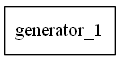

In [31]:
plot_model(generator, show_shapes=True)

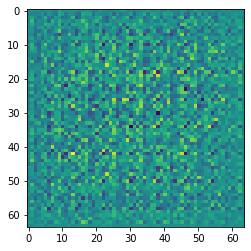

In [35]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [40]:
generated_image.shape

TensorShape([1, 64, 64, 3])

In [ ]:
def make_discriminator_model():
    filters = 64
    model = tf.keras.Sequential([])
    
    
    # 卷积-BN-激活函数:(b, 31, 31, 64)  (64 - 4 + 1) / 2 向上取整
    model.add(layers.Conv2DTranspose(filters=filters * 1, kernel_size=4, strides=2, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 4, 4, 512)
    model.add(layers.Conv2(filters=filters * 8, kernel_size=4, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 8, 8, 256)
    model.add(layers.Conv2DTranspose(filters=filters * 4, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 16, 16, 128)
    model.add(layers.Conv2DTranspose(filters=filters * 2, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    

    
    # 转置卷积-BN-激活函数:(b, 64, 64, 3)
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh'))
    return model